In [44]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [45]:
load_dotenv()

True

In [46]:
import os
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0, 
    api_key = os.getenv("GOOGLE_API_KEY")
)

In [47]:
loader = PyPDFLoader("xgboost research paper.pdf")
docs = loader.load()

In [48]:
len(docs)

13

In [49]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [50]:
embeddings = GoogleGenerativeAIEmbeddings(
    model="gemini-embedding-001",
    google_api_key=os.getenv("GOOGLE_API_KEY")
)


In [51]:
vectorstore = FAISS.from_documents(chunks, embeddings)

In [52]:
vectorstore

In [53]:

retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [54]:
@tool
def rag_tool(query: str) -> dict:

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [ ]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools) # telling llm that you have access of this tool.

In [56]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [57]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [58]:

tool_node = ToolNode(tools)

In [59]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

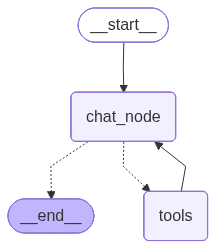

In [60]:
chatbot

In [64]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, who create xgboost and what are its main features?"
                )
            )
        ]
    }
)

In [65]:
print(result['messages'][-1].content)

[{'type': 'text', 'text': "XGBoost was created by Tianqi Chen and Carlos Guestrin from the University of Washington.\n\nIts main features include:\n*   **Scalability:** It runs over ten times faster than existing popular solutions on a single machine and can scale to billions of examples in distributed or memory-limited environments.\n*   **Novel tree learning algorithm:** This algorithm is designed to handle sparse data efficiently.\n*   **Weighted quantile sketch procedure:** This theoretically justified procedure allows for handling instance weights in approximate tree learning.\n*   **Out-of-core computing:** XGBoost exploits this to handle data that doesn't fit into memory.\n*   **Parallel and distributed computing:** This enables faster learning and quicker model exploration.\n*   **System and algorithmic optimizations:** These include insights on cache access patterns, data compression, and sharding to build a scalable tree boosting system.", 'extras': {'signature': 'Cr0GAXLI2nx